<a href="https://colab.research.google.com/github/gbouzioto/chemical_polution/blob/main/notebooks/model_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Statements

In [1]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [2]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
import os
import numpy
numpy.random.seed(1337)
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import tensorflow as tf
import tensorflow_addons as tfa
import os
import PIL

from tensorflow import keras
from tensorflow.keras.applications import InceptionV3, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import get_file
from tensorflow import expand_dims
from tensorflow.nn import softmax
from tensorflow.keras.models import Sequential, save_model, load_model
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#Tutorial https://www.tensorflow.org/tutorials/images/classification

## Load Dataset

In [4]:
project_dir = os.path.join('/', 'content')
dataset_file = os.path.join(project_dir, 'BlackSea.zip')
dataset_file_path = os.path.join(project_dir, 'BlackSea')

if not os.path.isdir(dataset_file_path):
    # download dataset if it does not exist
    url = 'http://users.uoa.gr/~nalygizakis/BS/Predicted%20spatial%20distribution%20dataset.zip'
    urllib.request.urlretrieve(url, dataset_file)
    # extract images
    with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_file_path)

dataset_train = os.path.join(dataset_file_path, 'train')
dataset_evaluation = os.path.join(dataset_file_path, 'evaluation')

In [5]:
dataset_train

'/content/BlackSea/train'

In [6]:
dataset_evaluation

'/content/BlackSea/evaluation'

## Train, Validation and Test Generators

In [7]:
batch_size = 32
img_height = 150
img_width = 150

In [8]:
datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

In [9]:
train_generator = datagen.flow_from_directory(
    dataset_train, 
    target_size=(img_height, img_width), 
    batch_size=batch_size, 
    class_mode='categorical', 
    subset='training')

Found 1126 images belonging to 3 classes.


In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'BlackSea/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1406 files belonging to 3 classes.
Using 1125 files for training.


['Danube', 'Dnieper', 'UnknownOrigin']


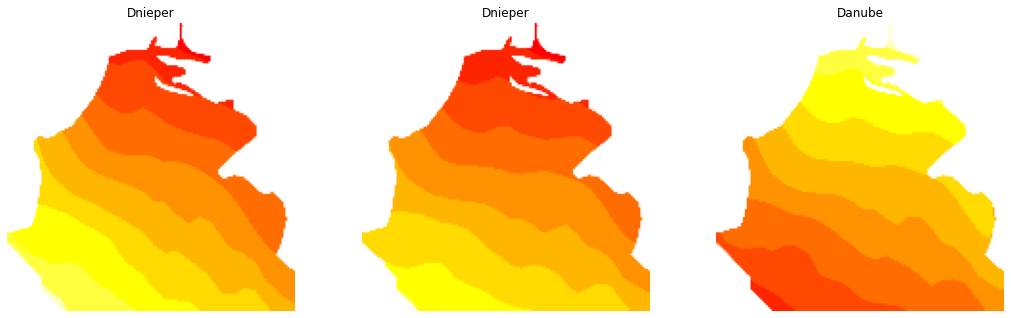

In [11]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(18, 18))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
validation_generator = datagen.flow_from_directory(
    dataset_train, 
    target_size=(img_height, img_width), 
    batch_size=batch_size, 
    class_mode='categorical', 
    subset='validation')

Found 280 images belonging to 3 classes.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'BlackSea/train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1406 files belonging to 3 classes.
Using 281 files for validation.


In [14]:
#AUTOTUNE = tf.data.AUTOTUNE
#
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
test_generator = datagen.flow_from_directory(
    dataset_evaluation, 
    target_size=(img_height, img_height), 
    batch_size=batch_size, 
    shuffle = False,
    class_mode='categorical')

Found 224 images belonging to 3 classes.


In [16]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'BlackSea/evaluation',
  seed=123,
  image_size=(img_height, img_width),
  shuffle = False,
  batch_size=batch_size)

Found 224 files belonging to 3 classes.


The number of images are correct. We have in total 1406 which were split in training set (1126 images) and validation set (280 images). Finally there are 224 images as the test set.

In [17]:
test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size)
print(test_steps_per_epoch)

7


In [18]:
num_classes = 3

# 1.Basic tensorflow CNN

In [21]:
model_CNN1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model_CNN1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['acc', f1_m, precision_m, recall_m])

In [23]:
model_CNN1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 37, 37, 32)        0

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='f1_m', patience=10)
epochs = 100

In [25]:
history_CNN1 = model_CNN1.fit(train_ds,
                    validation_data=val_ds,
                    callbacks=[callback],
                    epochs=epochs)

Epoch 1/100
36/36 [==============================] - 27s 695ms/step - loss: 0.7731 - acc: 0.8516 - f1_m: 0.7035 - precision_m: 0.5469 - recall_m: 1.2629 - val_loss: 0.0437 - val_acc: 0.9893 - val_f1_m: 0.6415 - val_precision_m: 0.4454 - val_recall_m: 1.1716
Epoch 2/100
36/36 [==============================] - 27s 730ms/step - loss: 0.0632 - acc: 0.9813 - f1_m: 0.7927 - precision_m: 0.5693 - recall_m: 1.3403 - val_loss: 0.0602 - val_acc: 0.9893 - val_f1_m: 0.7156 - val_precision_m: 0.4892 - val_recall_m: 1.3591
Epoch 3/100
36/36 [==============================] - 27s 732ms/step - loss: 0.0725 - acc: 0.9769 - f1_m: 0.8274 - precision_m: 0.5956 - recall_m: 1.3923 - val_loss: 0.0248 - val_acc: 0.9929 - val_f1_m: 0.7882 - val_precision_m: 0.5609 - val_recall_m: 1.3657
Epoch 4/100
36/36 [==============================] - 24s 663ms/step - loss: 0.0413 - acc: 0.9858 - f1_m: 0.8497 - precision_m: 0.5986 - recall_m: 1.5068 - val_loss: 0.0313 - val_acc: 0.9893 - val_f1_m: 0.8062 - val_precision_m

In [26]:
score = model_CNN1.evaluate(test_ds, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


# Save the model
filepath = './model_CNN1'
save_model(model_CNN1, filepath)

# Load the model
model = load_model(filepath, compile = False)

Test loss: 0.02286449447274208
Test accuracy: 1.0
INFO:tensorflow:Assets written to: ./model_CNN1/assets


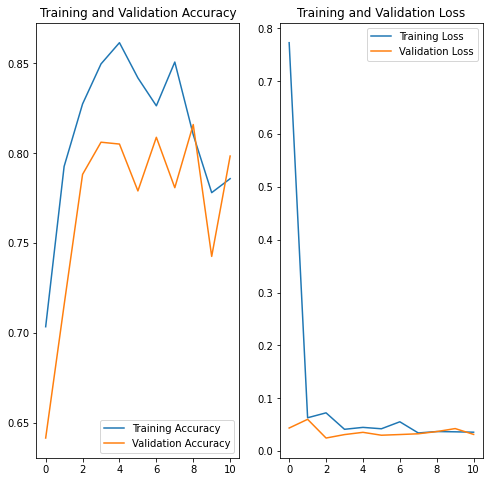

In [27]:
acc = history_CNN1.history['f1_m']
val_acc = history_CNN1.history['val_f1_m']

loss = history_CNN1.history['loss']
val_loss = history_CNN1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
predictions = model_CNN1.predict(test_ds, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

In [29]:
true_classes = test_generator.classes #true_classes = test_ds.class_names
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2], dtype=int32)

In [30]:
class_labels = list(test_generator.class_indices.keys())
class_labels

['Danube', 'Dnieper', 'UnknownOrigin']

               precision    recall  f1-score   support

       Danube       1.00      1.00      1.00       109
      Dnieper       1.00      1.00      1.00        78
UnknownOrigin       1.00      1.00      1.00        37

     accuracy                           1.00       224
    macro avg       1.00      1.00      1.00       224
 weighted avg       1.00      1.00      1.00       224



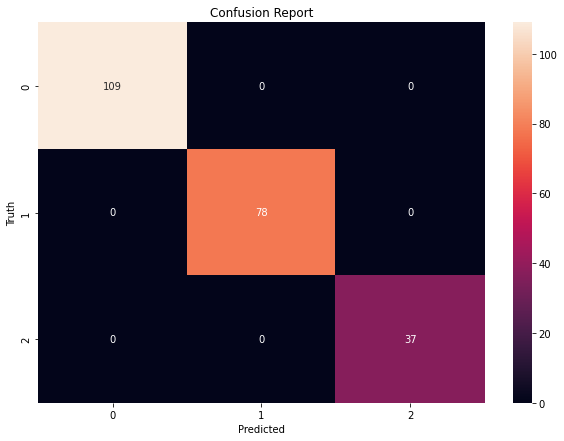

In [31]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)
print(report)
cmrforest = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cmrforest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Report')
plt.show()

# Predictions

In [47]:
dataset_for_prediction = os.path.join(dataset_file_path, 'prediction')
dataset_for_prediction

'/content/BlackSea/prediction'

In [48]:
dataset_for_prediction = datagen.flow_from_directory(
    dataset_for_prediction, 
    target_size=(img_height, img_height), 
    batch_size=batch_size, 
    shuffle = False,
    class_mode='categorical')

Found 30489 images belonging to 1 classes.


In [49]:
dataset_for_prediction = tf.keras.preprocessing.image_dataset_from_directory(
  'BlackSea/prediction',
  seed=123,
  image_size=(img_height, img_width),
  shuffle = False,
  batch_size=batch_size)

Found 30489 files belonging to 1 classes.


In [50]:
predictions = model_CNN1.predict(dataset_for_prediction)

In [51]:
len(predictions)

30489

In [52]:
predictions[1:10]

array([[ 5.3017187,  1.0853667, -7.0040984],
       [-4.7547708,  7.3037767, -1.4437723],
       [ 5.006926 , -1.0553998, -2.2026606],
       [ 9.155664 , -2.329165 , -5.8794293],
       [-4.678572 ,  7.4452076, -1.6684153],
       [-3.7419634,  7.634418 , -2.8910692],
       [-4.737501 ,  7.3450694, -1.502234 ],
       [-3.993742 ,  4.8222804,  0.8692965],
       [-3.5704474,  7.642258 , -3.1189241]], dtype=float32)

In [43]:
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)
predicted_classes
len(predicted_classes)

30489

In [54]:
files_for_prediction = dataset_for_prediction.file_paths

In [56]:
import pandas as pd
df = pd.DataFrame({'x':files_for_prediction, 'y':predicted_classes})

In [57]:
df.to_csv("results.csv")